In [1]:
import scanpy as sc
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
## path to repository
os.chdir('/hpcnfs/scratch/DIMA/piva/mpi_freiburg/scmultiome/')


In [4]:

## already Normalized ATAC assay
# assay peaks were called in WT only cells, linking was done only in wt and mutants have been requantified afterwards
# so, 1st linked peak is first linked peak in WT.

adata_path='./data/wt_only_linked_with_mutants_norm.h5ad'
adata=sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 22358 × 43277
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.09_556', 'doublets', 'dataset', 'pANN_0.25_0.09_978', 'pANN_0.25_0.09_143', 'pANN_0.25_0.09_477', 'pANN_0.25_0.09_359', 'pANN_0.25_0.09_20', 'pANN_0.25_0.09_136', 'pANN_0.25_0.09_70', 'pANN_0.25_0.09_1488', 'pANN_0.25_0.09_1159', 'pANN_0.25_0.09_399', 'pANN_0.25_0.09_832', 'sample', 'stage', 'replicate', 'nCount_ATAC', 'nFeature_ATAC', 'integrated_snn_res.0.8', 'annotation_leiden12', 'nCount_peaks', 'nFeature_peaks', 'ident'
    uns: 'X_name'
    obsm: 'LSI', 'UMAP'
    layers: 'logcounts'

In [5]:
adata.X.sum(1).min(), adata.X.sum(1).max() 

(874.512674454011, 22938.601797532203)

In [6]:
np.min(adata.X), np.max(adata.X)

(0.0, 13.10498446591918)

## Marker genes

In [7]:
germlayer_markergenes=pd.read_csv('germlayer_markergenes.csv').drop(['Unnamed: 0','index'],1)
germlayer_markergenes=dict(zip(germlayer_markergenes['gene'], germlayer_markergenes['germlayer']))

In [8]:
germlayer_markergenes2=pd.read_csv('germlayer_markergenes.csv').drop(['Unnamed: 0','index'],1)
#germlayer_markergenes2.groupby('germlayer').apply(list)

In [9]:
markergenes=germlayer_markergenes2.groupby('germlayer')['gene'].apply(list).to_dict()

In [10]:
adata.var['chr']=[e.split('-')[0] for e in adata.var.index.tolist()]
adata.var['start']=[e.split('-')[-2] for e in adata.var.index.tolist()]
adata.var['end']=[e.split('-')[-1] for e in adata.var.index.tolist()]

In [11]:
adata.var

,chr,start,end
chr2L-563-1274,chr2L,563,1274
chr2L-1648-2058,chr2L,1648,2058
chr2L-5334-6147,chr2L,5334,6147
chr2L-7459-9247,chr2L,7459,9247
chr2L-12064-12996,chr2L,12064,12996
...,...,...,...
chrY-3653011-3653695,chrY,3653011,3653695
chrY-3654745-3655231,chrY,3654745,3655231
chrY-3655664-3656275,chrY,3655664,3656275
chrY-3665573-3666557,chrY,3665573,3666557


## peaks associated to marker genes

In [12]:
peaks=pd.read_excel('./data/table_1st_TSS_1st_enhancer_peaks_per_sample.xlsx',
                   )
peaks.head()

,gene,flybaseid,germlayer,WT_1st_TSS_peak,WT_1st_linked_enhancer_peak
0,GEFmeso,FBgn0050115,mesoderm,chr2R-18582263-18583747,chr2R-18568255-18569046
1,Mes2,FBgn0037207,mesoderm,chr3L-22944870-22945955,chr3L-22943258-22943944
2,NetA,FBgn0015773,mesoderm,chrX-14653509-14654386,chrX-14649351-14650189
3,ltl,FBgn0268063,mesoderm,chr3L-7518486-7520011,NaN
4,sna,FBgn0003448,mesoderm,chr2L-15476900-15478776,chr2L-15479413-15480254


In [13]:
# manually correcting 
peaks.at[ peaks[peaks['gene']=='Ptx1'].index[0], 'WT_1st_linked_enhancer_peak']=np.nan
peaks.at[ peaks[peaks['gene']=='Doc1'].index[0], 'WT_1st_linked_enhancer_peak']='chr3L-9028885-9030154'

In [14]:
## TSS
tss_peaks=peaks['WT_1st_TSS_peak'].dropna().tolist()
ehn_peaks=peaks['WT_1st_linked_enhancer_peak'].dropna().tolist()

In [15]:
len(set(tss_peaks)), len(tss_peaks)

(51, 51)

In [16]:
len(set(ehn_peaks)), len(ehn_peaks)

(43, 44)

In [17]:
peaks[peaks['WT_1st_linked_enhancer_peak'].isin( peaks['WT_1st_linked_enhancer_peak'][peaks['WT_1st_linked_enhancer_peak'].duplicated()].tolist() ) ]

,gene,flybaseid,germlayer,WT_1st_TSS_peak,WT_1st_linked_enhancer_peak
3,ltl,FBgn0268063,mesoderm,chr3L-7518486-7520011,NaN
18,Doc2,FBgn0035956,dorsal_ectoderm,chr3L-9018989-9019778,chr3L-9002489-9003876
19,Doc3,FBgn0035954,dorsal_ectoderm,chr3L-9004765-9005578,chr3L-9002489-9003876
21,peb,FBgn0003053,dorsal_ectoderm,chrX-4616160-4617783,NaN
25,l(1)sc,FBgn0002561,neuroectoderm,chrX-409138-410322,NaN
32,geko,FBgn0020300,ventral_ectoderm,chr3L-18138075-18139990,NaN
41,CG2930,FBgn0028491,posterior_endoderm,chrX-3868762-3869710,NaN
42,Ptx1,FBgn0020912,posterior_endoderm,chr3R-30911997-30913085,NaN
49,sisA,FBgn0003411,yolk,chrX-11321889-11323310,NaN
50,Corp,FBgn0030028,yolk,chrX-8271108-8271973,NaN


In [18]:
peaks[peaks['gene'].isin(['Ptx1', 'Doc1'])]#.index

,gene,flybaseid,germlayer,WT_1st_TSS_peak,WT_1st_linked_enhancer_peak
17,Doc1,FBgn0028789,dorsal_ectoderm,chr3L-9040741-9041644,chr3L-9028885-9030154
42,Ptx1,FBgn0020912,posterior_endoderm,chr3R-30911997-30913085,NaN


In [19]:
# chr3L-9040741-9041644

In [20]:
adata.var.loc['chr3L-9028885-9030154']

chr        chr3L
start    9028885
end      9030154
Name: chr3L-9028885-9030154, dtype: object

In [21]:
order_germ=['mesoderm',
 'anterioposterior_ectoderm',
 'dorsal_ectoderm',
 'neuroectoderm',
 'ventral_ectoderm',
 'anterior_endoderm',
 'posterior_endoderm','yolk',
 'undifferentiated_cells']

## Fold Change - CBP vs wt

In [21]:
adata.obs['sample'].value_counts()

wt     13931
ez      6376
nej     2051
Name: sample, dtype: int64

In [22]:
adata.obs['group']=adata.obs['sample'].astype(str)+'-'+adata.obs['annotation_leiden12'].astype(str)

In [23]:
pairs_dict={
        'yolk':  ['nej-yolk','wt-yolk'],
        'undifferentiated_cells':['nej-undifferentiated_cells','wt-undifferentiated_cells']
}

In [24]:
mutant='nej'

In [25]:

peaks_related_to_markers=tss_peaks#+ehn_peaks

In [26]:
resfc={}
resppv={}
for k,v in pairs_dict.items():
    sc.tl.rank_genes_groups(adata, 'group', groups=[v[0]], reference=v[1],
                            method='wilcoxon',corr_method='benjamini-hochberg', key_added = "%s_wilcoxon"%(k))

    result = adata.uns["%s_wilcoxon"%(k)]
    groups = result['names'].dtype.names
    result = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

    result.set_index('%s-%s_names'%(mutant, k),inplace=True)
    result=result.loc[peaks_related_to_markers]
    
    resfc['%s-%s_logfoldchanges'%(mutant, k)]=result['%s-%s_logfoldchanges'%(mutant, k)]
    resppv['%s-%s_pvals_adj'%(mutant, k)]=result['%s-%s_pvals_adj'%(mutant, k)]
    
    
resfc_tot=resfc.copy()
resppv_tot=resppv.copy()

resfc_tot=pd.DataFrame.from_dict(resfc_tot)
resppv_tot=pd.DataFrame.from_dict(resppv_tot)


resfc_tss=resfc_tot

In [27]:
resfc_tss.head()

,nej-yolk_logfoldchanges,nej-undifferentiated_cells_logfoldchanges
chr2R-18582263-18583747,-0.989558,0.229646
chr3L-22944870-22945955,-0.929060,-0.224379
chrX-14653509-14654386,0.677618,0.167870
chr3L-7518486-7520011,-0.623032,-0.198480
chr2L-15476900-15478776,0.595135,0.891029


In [28]:
## peaks to genes

resfc_tss=peaks[['gene','WT_1st_TSS_peak']].merge(resfc_tss, left_on='WT_1st_TSS_peak', right_index=True, how='outer' )
resfc_tss.drop('WT_1st_TSS_peak', axis=1, inplace=True)
resfc_tss.set_index('gene', inplace=True)

In [29]:
resfc_tss=resfc_tss.loc[peaks['gene']]

In [30]:
resfc_tss.head()

,nej-yolk_logfoldchanges,nej-undifferentiated_cells_logfoldchanges
gene,,
GEFmeso,-0.989558,0.229646
Mes2,-0.929060,-0.224379
NetA,0.677618,0.167870
ltl,-0.623032,-0.198480
sna,0.595135,0.891029


In [31]:
import matplotlib
cmap = matplotlib.colormaps.get_cmap('PiYG')  # viridis is the default colormap for imshow
cmap.set_bad(color='lightgrey')

In [32]:
cmap_greygreen = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                                     # list(sns.color_palette('PiYG',3))+['White']+list(sns.color_palette('YlGn',3))) 
                                                                     ['White','White','Green'])
cmap_greygreen.set_bad(color='lightgrey')

In [33]:
# palette purple to greens (tss/enh)

cmap_purplegreen_tss = matplotlib.colors.LinearSegmentedColormap.from_list("", list(sns.color_palette('PiYG',9)[:3])+[ "white", '#59bab3', '#32a59c', '#159b91']) 
cmap_purplegreen_enh = matplotlib.colors.LinearSegmentedColormap.from_list("", list(sns.color_palette('PiYG',9)[:3])+[ "white", '#7fc16d', '#50b957', '#2bb54e']) 
cmap_purplegreen_tss.set_bad(color='lightgrey')
cmap_purplegreen_enh.set_bad(color='lightgrey')                                                   

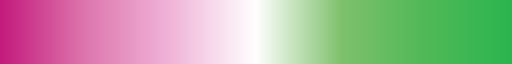

In [34]:
cmap_purplegreen_enh

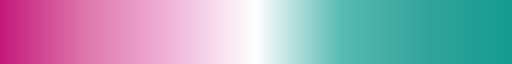

In [35]:
cmap_purplegreen_tss

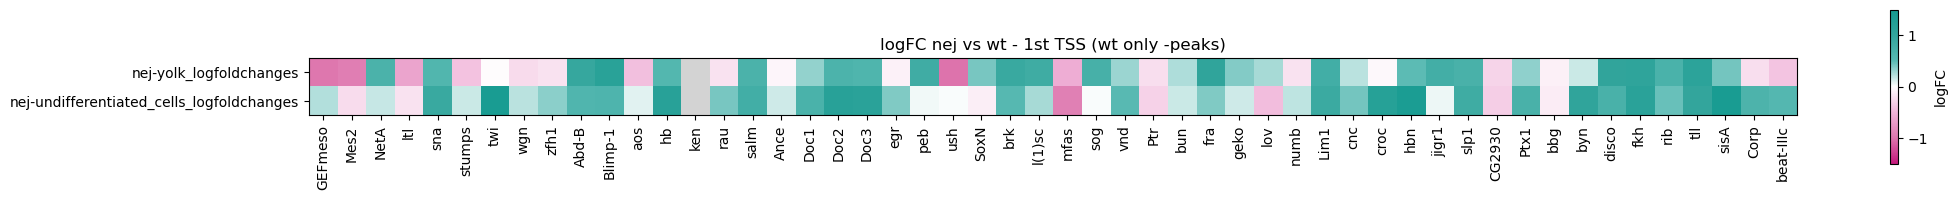

In [36]:
from matplotlib import colors
import matplotlib.pyplot as plt
divnorm=colors.TwoSlopeNorm(vmin=-1.5, vcenter=0., vmax=1.5)

fig,axs=plt.subplots(1,1,figsize=(24,2))
shw1=plt.imshow(resfc_tss.T,cmap=cmap_purplegreen_tss, #cmap, #'PiYG',#linewidths=0.2, linecolor='white',  #annot=True, 
            norm=divnorm, )
plt.grid(visible=False)
plt.title('logFC %s vs wt - 1st TSS (wt only -peaks)'%(mutant))
plt.xlabel('')
axs.set_xticks(np.arange(len(resfc_tss.index)))
axs.set_xticklabels(resfc_tss.index,rotation=90 )
axs.set_yticks(np.arange(len(resfc_tss.columns)))
axs.set_yticklabels(resfc_tss.columns,rotation=0 )
bar1 = plt.colorbar(shw1)
bar1.set_label('logFC')

#plt.savefig('./figures/heatmap_%s_vs_wt_1st_TSS_wtpeaks_markers.pdf'%(mutant))

In [43]:
resppv_tot.index=resppv_tot.index.map(dict(zip(peaks['WT_1st_TSS_peak'], peaks['gene'])))

In [47]:
resfc_df=resfc_tss.copy()
resppv_df=resppv_tot.copy()

save_df=pd.concat([resppv_df, resfc_df], axis=1)

save_df.columns=[e.replace('nej-', 'CBPKD_vs_wt-') for e in save_df.columns.tolist() ]

col=save_df.columns.tolist()
col.sort()

save_df=save_df[col]
save_df['peak']=save_df.index.map(dict(zip( peaks['gene'], peaks['WT_1st_TSS_peak'])))

### Enhancers

In [50]:
peaks_related_to_markers=list(set(ehn_peaks))

In [51]:
## Enhancers

resfc={}
resppv={}
for k,v in pairs_dict.items():
    sc.tl.rank_genes_groups(adata, 'group', groups=[v[0]], reference=v[1],
                            method='wilcoxon',corr_method='benjamini-hochberg', key_added = "%s_wilcoxon"%(k))

    result = adata.uns["%s_wilcoxon"%(k)]
    groups = result['names'].dtype.names
    result = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
   # resfc[k]=[result[['ez-%s_names'%(k),'ez-%s_logfoldchanges'%(k)]]  ]  # considering pvalue?
    result.set_index('%s-%s_names'%(mutant,k),inplace=True)
    
    result=result.loc[peaks_related_to_markers]
    
    resfc['%s-%s_logfoldchanges'%(mutant, k)]=result['%s-%s_logfoldchanges'%(mutant, k)]
    resppv['%s-%s_pvals_adj'%(mutant, k)]=result['%s-%s_pvals_adj'%(mutant, k)]
    

    
resfc_tot=resfc.copy()
resppv_tot=resppv.copy()

resfc_tot=pd.DataFrame.from_dict(resfc_tot)
resppv_tot=pd.DataFrame.from_dict(resppv_tot)

resfc_ehn=resfc_tot

In [52]:
resfc_ehn.head()

,nej-yolk_logfoldchanges,nej-undifferentiated_cells_logfoldchanges
chr2R-23049540-23050290,-1.395358,-0.191668
chr3L-21479468-21480937,0.060249,0.832409
chrX-18626866-18627815,-1.074570,0.168447
chr2L-8826626-8828591,0.289061,-0.440455
chrX-583728-584754,-0.233145,0.678718


In [53]:
resfc_ehn.shape

(43, 2)

In [54]:
## peaks to genes

resfc_ehn=peaks[['gene','WT_1st_linked_enhancer_peak']].merge(resfc_ehn, left_on='WT_1st_linked_enhancer_peak', right_index=True, how='outer' )
resfc_ehn.drop('WT_1st_linked_enhancer_peak', axis=1, inplace=True)
resfc_ehn.set_index('gene', inplace=True)

In [55]:
resfc_ehn=resfc_ehn.loc[peaks['gene']]

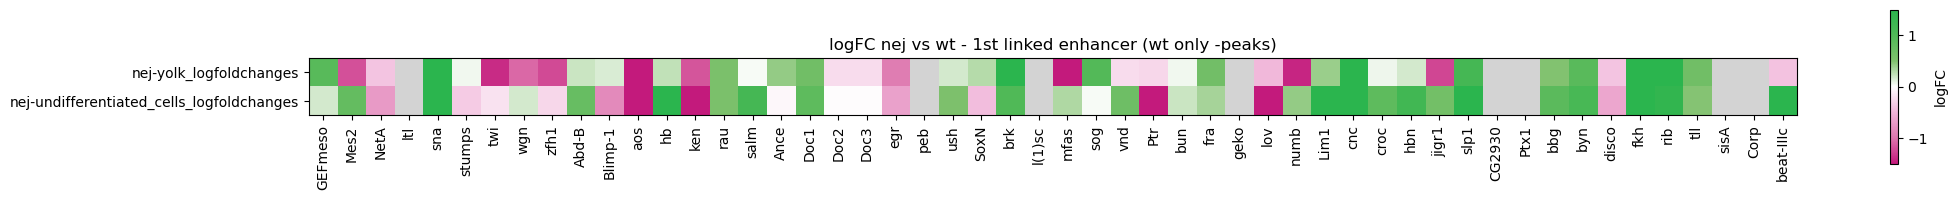

In [56]:
divnorm=colors.TwoSlopeNorm(vmin=-1.5, vcenter=0., vmax=1.5)

fig,axs=plt.subplots(1,1,figsize=(24,2))
shw1=plt.imshow(resfc_ehn.T,cmap=cmap_purplegreen_enh, #cmap_greygreen, #cmap, #'PiYG',#linewidths=0.2, linecolor='white',  #annot=True, 
            norm=divnorm, )
plt.grid(visible=False)
plt.title('logFC %s vs wt - 1st linked enhancer (wt only -peaks)'%(mutant))
plt.xlabel('')
axs.set_xticks(np.arange(len(resfc_ehn.index)))
axs.set_xticklabels(resfc_ehn.index,rotation=90 )
axs.set_yticks(np.arange(len(resfc_ehn.columns)))
axs.set_yticklabels(resfc_ehn.columns,rotation=0 )
bar1 = plt.colorbar(shw1)
bar1.set_label('logFC')

#plt.savefig('./figures/heatmap_%s_vs_wt_1st_enhancer_wtpeaks_markers.pdf'%(mutant))

In [1]:

import session_info
session_info.show()